Extracting the data

In [11]:
!tar -xvzf cifar-10-python.tar.gz
!tar -xvzf cifar-100-python.tar.gz

x cifar-10-batches-py/
x cifar-10-batches-py/data_batch_4
x cifar-10-batches-py/readme.html
x cifar-10-batches-py/test_batch
x cifar-10-batches-py/data_batch_3
x cifar-10-batches-py/batches.meta
x cifar-10-batches-py/data_batch_2
x cifar-10-batches-py/data_batch_5
x cifar-10-batches-py/data_batch_1
x cifar-100-python/
x cifar-100-python/file.txt~
x cifar-100-python/train
x cifar-100-python/test
x cifar-100-python/meta


Load CIFAR10 (And print classes to find the ids)

In [12]:
import pickle
import numpy as np
import pandas as pd
import os

def unpickle(file):
    with open(file, 'rb') as f:
        return pickle.load(f, encoding='bytes')

# CIFAR-10
meta10 = unpickle("cifar-10-batches-py/batches.meta")
cifar10_classes = [x.decode('utf-8') for x in meta10[b'label_names']]

print("CIFAR-10 classes:")
for i, name in enumerate(cifar10_classes):
    print(i, name)

CIFAR-10 classes:
0 airplane
1 automobile
2 bird
3 cat
4 deer
5 dog
6 frog
7 horse
8 ship
9 truck


Load CIFAR100 (And print classes to find the ids)

In [ ]:
# CIFAR-100
meta100 = unpickle("cifar-100-python/meta")
cifar100_fine_classes = [x.decode('utf-8') for x in meta100[b'fine_label_names']]
cifar100_coarse_classes = [x.decode('utf-8') for x in meta100[b'coarse_label_names']]

print("\nCIFAR-100 fine labels (100 classes):")
for i, name in enumerate(cifar100_fine_classes):
    print(i, name)


CIFAR-100 fine labels (100 classes):
0 apple
1 aquarium_fish
2 baby
3 bear
4 beaver
5 bed
6 bee
7 beetle
8 bicycle
9 bottle
10 bowl
11 boy
12 bridge
13 bus
14 butterfly
15 camel
16 can
17 castle
18 caterpillar
19 cattle
20 chair
21 chimpanzee
22 clock
23 cloud
24 cockroach
25 couch
26 crab
27 crocodile
28 cup
29 dinosaur
30 dolphin
31 elephant
32 flatfish
33 forest
34 fox
35 girl
36 hamster
37 house
38 kangaroo
39 keyboard
40 lamp
41 lawn_mower
42 leopard
43 lion
44 lizard
45 lobster
46 man
47 maple_tree
48 motorcycle
49 mountain
50 mouse
51 mushroom
52 oak_tree
53 orange
54 orchid
55 otter
56 palm_tree
57 pear
58 pickup_truck
59 pine_tree
60 plain
61 plate
62 poppy
63 porcupine
64 possum
65 rabbit
66 raccoon
67 ray
68 road
69 rocket
70 rose
71 sea
72 seal
73 shark
74 shrew
75 skunk
76 skyscraper
77 snail
78 snake
79 spider
80 squirrel
81 streetcar
82 sunflower
83 sweet_pepper
84 table
85 tank
86 telephone
87 television
88 tiger
89 tractor
90 train
91 trout
92 tulip
93 turtle
94 wardr

Extract the ids we need for CIFAR-10

In [14]:
cifar10_needed_ids = [1, 2, 3, 4, 5, 7, 9] # automobile, bird, cat, deer, dog, horse, truck

X_train_10 = []
y_train_10 = []

for i in range(1, 6):
    batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_train_10.append(batch[b'data'])
    y_train_10.append(batch[b'labels'])

X_train_10 = np.concatenate(X_train_10)
y_train_10 = np.concatenate(y_train_10)

# filter only needed CIFAR-10 classes
train_mask_10 = np.isin(y_train_10, cifar10_needed_ids)
X_train_10_filtered = X_train_10[train_mask_10]
y_train_10_filtered = y_train_10[train_mask_10]

# filter CIFAR-10 test batch
test_batch = unpickle("cifar-10-batches-py/test_batch")
X_test_10 = test_batch[b'data']
y_test_10 = np.array(test_batch[b'labels'])

test_mask_10 = np.isin(y_test_10, cifar10_needed_ids)
X_test_10_filtered = X_test_10[test_mask_10]
y_test_10_filtered = y_test_10[test_mask_10]

print(X_train_10_filtered.shape, y_train_10_filtered.shape)
print(X_test_10_filtered.shape, y_test_10_filtered.shape)

(35000, 3072) (35000,)
(7000, 3072) (7000,)


The shape of these matrices make sense as <br>
X_train_10 filtered 50,000 training images and we only took 7 classes out of 10 so that is 35,000, and it has 32px x 32px x 3(RGB) = 3072. y_train_10 filtered is also 35000 <br>
X_test_filtered has 7000 rows which makes sense as we originally had 10000 but took only 7 classes out of 10

Extract the ids we need for CIFAR-100

In [15]:
cifar100_needed_ids = [4, 6, 7, 9, 11, 12, 13, 18, 20, 21, 33, 34, 35, 38, 46, 49, 54]

train_100 = unpickle("cifar-100-python/train")
X_train_100 = train_100[b'data']
y_train_100 = np.array(train_100[b'fine_labels'])

test_100 = unpickle("cifar-100-python/test")
X_test_100 = test_100[b'data']
y_test_100 = np.array(test_100[b'fine_labels'])

# Filter only needed classes
train_mask_100 = np.isin(y_train_100, cifar100_needed_ids)
X_train_100_filtered = X_train_100[train_mask_100]
y_train_100_filtered = y_train_100[train_mask_100]

test_mask_100 = np.isin(y_test_100, cifar100_needed_ids)
X_test_100_filtered = X_test_100[test_mask_100]
y_test_100_filtered = y_test_100[test_mask_100]

print(X_train_100_filtered.shape, y_train_100_filtered.shape)
print(X_test_100_filtered.shape, y_test_100_filtered.shape)

(8500, 3072) (8500,)
(1700, 3072) (1700,)


Same here for CIFAR-100, we had 50,000 images but took 17 classes so 8500 images <br>
The test data had 10,000 but we took 17 so now 1700

Combine CIFAR-10 and CIFAR-100 and save files

In [16]:
X_train_combined = np.concatenate([X_train_10_filtered, X_train_100_filtered])
y_train_combined = np.concatenate([y_train_10_filtered, y_train_100_filtered])

X_test_combined = np.concatenate([X_test_10_filtered, X_test_100_filtered])
y_test_combined = np.concatenate([y_test_10_filtered, y_test_100_filtered])

print(X_train_combined.shape, y_train_combined.shape)
print(X_test_combined.shape, y_test_combined.shape)

os.makedirs('combined', exist_ok=True)

train_data = {'features': X_train_combined, 'labels': y_train_combined}
test_data  = {'features': X_test_combined, 'labels': y_test_combined}

# 0.1 for 10% of training split
val_split = int(0.1 * X_train_combined.shape[0])
val_data = {'features': X_train_combined[:val_split], 'labels': y_train_combined[:val_split]}
train_data = {'features': X_train_combined[val_split:], 'labels': y_train_combined[val_split:]}

with open('combined/train.p', 'wb') as f:
    pickle.dump(train_data, f)
with open('combined/valid.p', 'wb') as f:
    pickle.dump(val_data, f)
with open('combined/test.p', 'wb') as f:
    pickle.dump(test_data, f)

(43500, 3072) (43500,)
(8700, 3072) (8700,)


Now we are reading in the train_data, val_data and test_data that we just created and checking the shape

In [17]:
import matplotlib.pyplot as plt

with open('combined/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('combined/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('combined/test.p', 'rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(39150, 3072) (4350, 3072) (8700, 3072)
(39150,) (4350,) (8700,)


We need to reshape it to the correct size to be able to apply pre-processing to it

In [ ]:
X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print(X_train.shape, X_val.shape, X_test.shape)

(39150, 32, 32, 3) (4350, 32, 32, 3) (8700, 32, 32, 3)


### Grayscale

(39150, 32, 32)
(4350, 32, 32)
(8700, 32, 32)


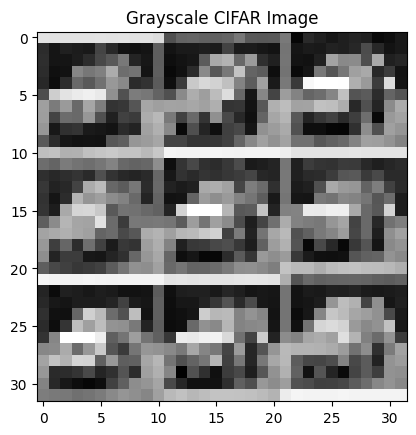

In [ ]:
import cv2

def grayscale(img):
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    return gray

X_train_gray = np.array([grayscale(img) for img in X_train])
X_val_gray = np.array([grayscale(img) for img in X_val])
X_test_gray = np.array([grayscale(img) for img in X_test])

print(X_train_gray.shape)
print(X_val_gray.shape)
print(X_test_gray.shape)

plt.imshow(X_train_gray[0], cmap="gray")
plt.title("Grayscale CIFAR Image")
plt.show()

### Gaussian Blur

(39150, 32, 32)
(4350, 32, 32)
(8700, 32, 32)


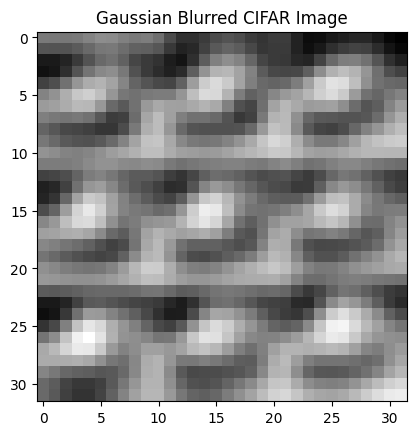

In [28]:
def gaussian_blur(img, ksize=(5, 5), sigma=0):
    return cv2.GaussianBlur(img, ksize, sigma)

X_train_blur = np.array([gaussian_blur(img) for img in X_train_gray])
X_val_blur = np.array([gaussian_blur(img) for img in X_val_gray])
X_test_blur = np.array([gaussian_blur(img) for img in X_test_gray])

print(X_train_blur.shape)
print(X_val_blur.shape)
print(X_test_blur.shape)

plt.imshow(X_train_blur[0], cmap="gray")
plt.title("Gaussian Blurred CIFAR Image")
plt.show()


### Equalizing Histogram

(39150, 32, 32)
(4350, 32, 32)
(8700, 32, 32)


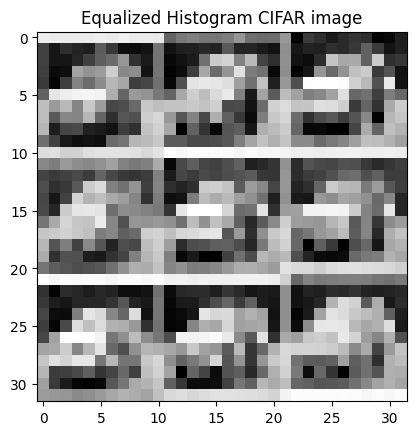

In [27]:
def equalize_histogram(img):
    return cv2.equalizeHist(img)

X_train_eq = np.array([equalize_histogram(img) for img in X_train_gray])
X_val_eq = np.array([equalize_histogram(img) for img in X_val_gray])
X_test_eq = np.array([equalize_histogram(img) for img in X_test_gray])

print(X_train_eq.shape)
print(X_val_eq.shape)
print(X_test_eq.shape)

plt.imshow(X_train_eq[0], cmap="gray")
plt.title("Equalized Histogram CIFAR image")
plt.show()

### Normalization

In [ ]:
# Start working on this once John goes through Normalization in class

### Resizing

(39150, 64, 64)
(4350, 64, 64)
(8700, 64, 64)


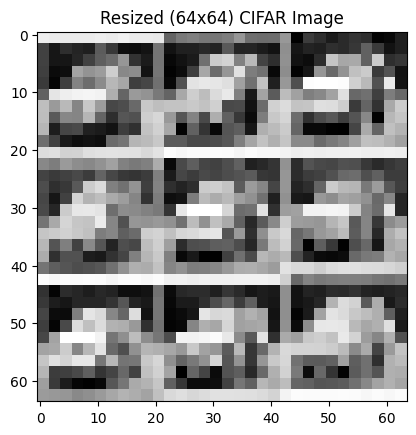

In [ ]:
def resize_image(img, size=(64, 64)):
    return cv2.resize(img, size, interpolation=cv2.INTER_AREA)

X_train_resized = np.array([resize_image(img) for img in X_train_eq])
X_val_resized = np.array([resize_image(img) for img in X_val_eq])
X_test_resized = np.array([resize_image(img) for img in X_test_eq])

print(X_train_resized.shape)
print(X_val_resized.shape)
print(X_test_resized.shape)

plt.imshow(X_train_resized[0], cmap="gray")
plt.title("Resized (64x64) CIFAR Image")
# plt.axis("off")
plt.show()